## Reading Zarr Data

[Zarr](https://zarr.readthedocs.io/en/stable/) is a storage format for chunked, N-dimensional arrays. It works well with object storage systems like [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction) and open-source libraries like [xarray](https://xarray.pydata.org/en/stable/). It's widely used in the geosciences, especially within the [Pangeo](https://pangeo.io/) community.

This example loads [Daymet](https://aka.ms/ai4edata-daymet) data that are stored in Zarr format into an xarray Dataset.  Daymet provides gridded weather data for North America.

In [1]:
import fsspec
import xarray as xr

store = fsspec.get_mapper('az://daymet-zarr/daily/hi.zarr', account_name="daymeteuwest")
ds = xr.open_zarr(store, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 284, y: 584)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(292, 284), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(292, 284), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -5.802e+06 -5.801e+06 ... -5.519e+06
  * y                        (y) float32 -3.9e+04 -4e+04 ... -6.21e+05 -6.22e+05
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(14600, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(14600,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        [1980]

At this point we can load the data, aggregate it, and plot it.

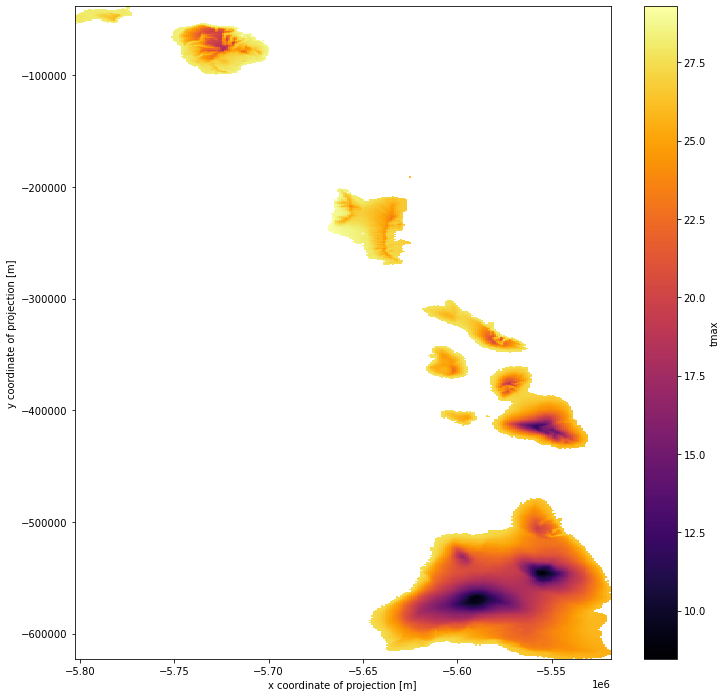

In [2]:
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", RuntimeWarning)
fig, ax = plt.subplots(figsize=(12, 12))
ds.sel(time="2009")["tmax"].mean(dim="time").plot.imshow(ax=ax, cmap="inferno");

### Learn more

The xarray [User Guide](https://xarray.pydata.org/en/stable/io.html#zarr) has more information on reading Zarr data. For more about the Daymet dataset, see [here](http://aka.ms/ai4edata-daymet).